# Clasificación de textos: Naive Bayes


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import random

from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    classification_report,
)
from sklearn.dummy import DummyClassifier
import nltk

nltk.download("movie_reviews")
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.corpus import movie_reviews


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
movie_reviews.categories()


['neg', 'pos']

In [ ]:
neg_review_fileids = movie_reviews.fileids("neg")
neg_review_fileids[:10]


['neg/cv000_29416.txt',
 'neg/cv001_19502.txt',
 'neg/cv002_17424.txt',
 'neg/cv003_12683.txt',
 'neg/cv004_12641.txt',
 'neg/cv005_29357.txt',
 'neg/cv006_17022.txt',
 'neg/cv007_4992.txt',
 'neg/cv008_29326.txt',
 'neg/cv009_29417.txt']

In [ ]:
print(movie_reviews.raw(neg_review_fileids[2]))


it is movies like these that make a jaded movie viewer thankful for the invention of the timex indiglo watch . 
based on the late 1960's television show by the same name , the mod squad tells the tale of three reformed criminals under the employ of the police to go undercover . 
however , things go wrong as evidence gets stolen and they are immediately under suspicion . 
of course , the ads make it seem like so much more . 
quick cuts , cool music , claire dane's nice hair and cute outfits , car chases , stuff blowing up , and the like . 
sounds like a cool movie , does it not ? 
after the first fifteen minutes , it quickly becomes apparent that it is not . 
the mod squad is certainly a slick looking production , complete with nice hair and costumes , but that simply isn't enough . 
the film is best described as a cross between an hour-long cop show and a music video , both stretched out into the span of an hour and a half . 
and with it comes every single clich ? . 
it doesn't really 

In [ ]:
documents = []

for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append((movie_reviews.raw(fileid), category))

df = pd.DataFrame(documents, columns=["review", "tag"])


In [ ]:
df = df.sample(frac=1, random_state=0).reset_index(drop=True).copy()
df.head()


review  tag
0  arnold schwarzenegger has been an icon for act...  neg
1  good films are hard to find these days . \ngre...  pos
2  quaid stars as a man who has taken up the prof...  pos
3  we could paraphrase michelle pfieffer's charac...  neg
4  kolya is one of the richest films i've seen in...  pos

In [ ]:
df.tag.value_counts()


neg    1000
pos    1000
Name: tag, dtype: int64

In [ ]:
train_test_split?


In [ ]:
# separamos entre train y test sets
X = df.review
y = df.tag
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=1234
)


In [ ]:
y_train.value_counts()


neg    800
pos    800
Name: tag, dtype: int64

In [ ]:
y_test.value_counts()


neg    200
pos    200
Name: tag, dtype: int64

#### Veamos un poco los textos


In [ ]:
X_train_text.tolist()[:5]


['wolfgang petersen\'s latest , the perfect storm , is like a pineapple . \nit only tastes good after arduous peeling and digging - if you try to eat the fruit , spikes and all , it\'s going to hurt ? quite a bit . \nok , maybe that was a confusing analogy , so here\'s my main complaint about the latest man battles nature flick : there isn\'t really much of a story to tell . \nbasically , a massachusetts fishing crew goes out to sea on a small boat , called the andrea gail , and gets stuck in the middle of " the storm of the century . " \nhow much time does it take for petersen to tell this story ? \nnot nearly enough . \nso he spends the majority of the film developing pointless side stories which all eventually become superfluous . \naudiences want to see the storm , they want to see a fight for survival but what they get is a lot of cliched , maudlin drivel . \nthe last quarter of the perfect storm is utterly perfect in every aspect , but just try lasting the first three-quarters . 

### Puedo definir una funcion para limpiar el texto y otra para tokenizar


In [ ]:
# En este caso particular no hace falta limpiar los textos
def clean_text(text):
    return text.strip()


In [ ]:
def tokenizer(text):
    # return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
    return word_tokenize(text)


tokenizer(clean_text(X_train_text.iloc[1]))[:10]


['i',
 'have',
 'to',
 'admit',
 'that',
 'i',
 'disliked',
 'this',
 'film',
 'initially']

### Puedo definir un stoplist


In [ ]:
stoplist = stopwords.words("english")


In [ ]:
stoplist[:15]


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [ ]:
# tokenizo el stoplist con el mismo tokenizar que voy a usar en el corpus
stoplist_tokenized = []
for w in stoplist:
    stoplist_tokenized = stoplist_tokenized + tokenizer(w)


In [ ]:
stoplist_tokenized[:15]


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 "'re",
 'you',
 "'ve",
 'you',
 "'ll"]

In [ ]:
# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))


### Extraigo Features


In [ ]:
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist_tokenized,
)
X_train = count_vect.fit_transform(
    X_train_text
)  # cuenta frecuencia de tokens y define el diccionario
X_test = count_vect.transform(
    X_test_text
)  # cuenta frecuencia de tokens existentes en el diccionario
X_train


<1600x11646 sparse matrix of type '<class 'numpy.int64'>'
	with 390555 stored elements in Compressed Sparse Row format>

In [ ]:
print("tamaño de la matriz:", 1600 * 11646)
print(
    "porcentaje de elementos distintos de cero: %",
    round(100 * 390555 / (1600 * 11646), 2),
)


tamaño de la matriz: 18633600
porcentaje de elementos distintos de cero: % 2.1


In [ ]:
count_vect.get_feature_names()[:20]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'60s",
 "'70s",
 "'80s",
 "'90s",
 "'97",
 "'cause",
 "'em",
 "'m",
 "'n",
 "'the",
 '(',
 ')',
 '*']

# Naive Bayes


In [ ]:
clf = MultinomialNB(alpha=1)  # alpha es el smoothing parameter
scores_cv_nb = cross_val_score(clf, X_train, y_train, cv=10, scoring="f1_macro")
scores_cv_nb


array([0.79987492, 0.84300797, 0.81857283, 0.86230637, 0.8437439 ,
       0.74964794, 0.82431373, 0.81874292, 0.79354839, 0.8125    ])

In [ ]:
print(
    "f-score=",
    round(scores_cv_nb.mean(), 4),
    " ( sd =",
    round(scores_cv_nb.std(), 4),
    ")",
)


f-score= 0.8166  ( sd = 0.0298 )


### Dummy


In [ ]:
clf_dummy = DummyClassifier(strategy="stratified")
scores_dummy_cv = cross_val_score(
    clf_dummy, X_train, y_train, cv=10, scoring="f1_macro"
)
print(
    "f-score=",
    round(scores_dummy_cv.mean(), 4),
    " ( sd =",
    round(scores_cv_nb.std(), 4),
    ")\n",
)


f-score= 0.4953  ( sd = 0.0298 )



## N-gramas


In [ ]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),
)
X_train_ngrams = count_vect.fit_transform(
    X_train_text
)  # cuenta frecuencia de tokens y define el diccionario
print("numero de features=", X_train_ngrams.shape[1])

scores_cv_ngrams = cross_val_score(
    clf, X_train_ngrams, y_train, cv=10, scoring="f1_macro"
)
print(
    "f-score=",
    round(scores_cv_ngrams.mean(), 4),
    " ( sd =",
    round(scores_cv_ngrams.std(), 4),
    ")",
)


numero de features= 26885
f-score= 0.8149  ( sd = 0.0261 )


In [ ]:
count_vect.get_feature_names()[:20]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['!',
 '! !',
 "! '",
 "! 'm",
 '! (',
 '! )',
 '! *',
 '! ,',
 '! .',
 '! ?',
 '! ``',
 '! also',
 '! even',
 '! film',
 '! joblo',
 '! know',
 '! like',
 '! movie',
 '! oh',
 '! one']

In [ ]:
# incluyo bigramas (aclaracion:si aparece "best friend" tambien va a contar para "best" y para "friend")
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist_tokenized,
)
X_train_ngrams_2 = count_vect.fit_transform(
    X_train_text
)  # cuenta frecuencia de tokens y define el diccionario
print("numero de features=", X_train_ngrams.shape[1])

scores_cv_ngrams_2 = cross_val_score(
    clf, X_train_ngrams_2, y_train, cv=10, scoring="f1_macro"
)
print(
    "f-score=",
    round(scores_cv_ngrams_2.mean(), 4),
    " ( sd =",
    round(scores_cv_ngrams_2.std(), 4),
    ")",
)


numero de features= 11646
f-score= 0.8166  ( sd = 0.0298 )


### Pruebo otros parametros


In [ ]:
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=30,
    stop_words=stoplist_tokenized,
    ngram_range=(1, 2),
)

X_train_ngrams = count_vect.fit_transform(
    X_train_text
)  # cuenta frecuencia de tokens y define el diccionario
print("numero de features =", X_train_ngrams.shape[1])

clf = MultinomialNB(alpha=1)
scores_cv_ngrams_v2 = cross_val_score(
    clf, X_train_ngrams, y_train, cv=10, scoring="f1_macro"
)
print(
    "f-score =",
    round(scores_cv_ngrams_v2.mean(), 4),
    " ( sd =",
    round(scores_cv_ngrams_v2.std(), 4),
    ")",
)


numero de features = 3850
f-score = 0.8142  ( sd = 0.0222 )


## Selecciono el mejor modelo


In [ ]:
pd.Series(
    {
        "NB (min_df=5)": round(scores_cv_nb.mean(), 3),
        "NB with ngrams (min_df=5)": round(scores_cv_ngrams.mean(), 3),
        "NB with ngrams (min_df=30)": round(scores_cv_ngrams_v2.mean(), 3),
    }
)


NB (min_df=5)                 0.817
NB with ngrams (min_df=5)     0.815
NB with ngrams (min_df=30)    0.814
dtype: float64

In [ ]:
count_vect = CountVectorizer(
    preprocessor=clean_text,
    tokenizer=tokenizer,
    min_df=5,
    stop_words=stoplist_tokenized,
    ngram_range=(1, 1),
)
X_train_ngrams = count_vect.fit_transform(
    X_train_text
)  # cuenta frecuencia de tokens y define el diccionario
X_test_ngrams = count_vect.transform(
    X_test_text
)  # cuenta frecuencia de tokens existentes en el diccionario
print("numero de features=", X_train_ngrams.shape[1])
# entreno el clasificador
clf = MultinomialNB(alpha=1).fit(X_train_ngrams, y_train)
# predigo en el set de testeo
y_pred = clf.predict(X_test_ngrams)
scores_ngrams = pd.Series(
    precision_recall_fscore_support(y_test, y_pred, average="macro")[:3],
    index=["precision", "recall", "fscore"],
)
print("\nNgrams\n")
print(scores_ngrams)
print("\nNmatriz de confusión\n", confusion_matrix(y_test, y_pred))


numero de features= 11646

Ngrams

precision    0.816138
recall       0.815000
fscore       0.814833
dtype: float64

Nmatriz de confusión
 [[169  31]
 [ 43 157]]


## Normalización


In [ ]:
# Stemizacion: lleva una palabra a su raíz (la cual puede no ser una palabra)
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
stemmer.stem("explanation")


'explan'

In [ ]:
[
    (w, stemmer.stem(w))
    for w in word_tokenize(clean_text(X_train_text.iloc[0]))
    if w.isalpha()
][:50]


[('wolfgang', 'wolfgang'),
 ('petersen', 'petersen'),
 ('latest', 'latest'),
 ('the', 'the'),
 ('perfect', 'perfect'),
 ('storm', 'storm'),
 ('is', 'is'),
 ('like', 'like'),
 ('a', 'a'),
 ('pineapple', 'pineappl'),
 ('it', 'it'),
 ('only', 'onli'),
 ('tastes', 'tast'),
 ('good', 'good'),
 ('after', 'after'),
 ('arduous', 'arduous'),
 ('peeling', 'peel'),
 ('and', 'and'),
 ('digging', 'dig'),
 ('if', 'if'),
 ('you', 'you'),
 ('try', 'tri'),
 ('to', 'to'),
 ('eat', 'eat'),
 ('the', 'the'),
 ('fruit', 'fruit'),
 ('spikes', 'spike'),
 ('and', 'and'),
 ('all', 'all'),
 ('it', 'it'),
 ('going', 'go'),
 ('to', 'to'),
 ('hurt', 'hurt'),
 ('quite', 'quit'),
 ('a', 'a'),
 ('bit', 'bit'),
 ('ok', 'ok'),
 ('maybe', 'mayb'),
 ('that', 'that'),
 ('was', 'was'),
 ('a', 'a'),
 ('confusing', 'confus'),
 ('analogy', 'analog'),
 ('so', 'so'),
 ('here', 'here'),
 ('my', 'my'),
 ('main', 'main'),
 ('complaint', 'complaint'),
 ('about', 'about'),
 ('the', 'the')]

#### notar que "empathy" y "empathize" no van a la misma raiz!


In [ ]:
print(stemmer.stem("empathy"))
print(stemmer.stem("empathize"))


empathi
empath


In [ ]:
# Lematizacion: lleva una palabra a su forma canónica
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download("omw-1.4")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")
wnl = WordNetLemmatizer()


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# para lemmatizar es necesario dar la categoria gramatical(part-of-speach)
# los POS validos son ("a","v","n","r")(adjetivo,verbo,sustantivo,advervio)
wnl.lemmatize(word="was", pos="v")


'be'

In [ ]:
postags = pos_tag(word_tokenize(clean_text(X_train_text.iloc[1])))
postags[:10]


[('i', 'NNS'),
 ('have', 'VBP'),
 ('to', 'TO'),
 ('admit', 'VB'),
 ('that', 'IN'),
 ('i', 'NN'),
 ('disliked', 'VBD'),
 ('this', 'DT'),
 ('film', 'NN'),
 ('initially', 'RB')]

In [ ]:
def word_pos_to_lemma(word, pos, wnl):
    if pos.startswith("J"):
        return wnl.lemmatize(word, wordnet.ADJ)  # adjetivo
    elif pos.startswith("V"):
        return wnl.lemmatize(word, wordnet.VERB)  # vervo
    elif pos.startswith("N"):
        return wnl.lemmatize(word, wordnet.NOUN)  # sustantivo
    elif pos.startswith("R"):
        return wnl.lemmatize(word, wordnet.ADV)  # advervio
    else:
        return wnl.lemmatize(word)


In [ ]:
[(w, word_pos_to_lemma(w, pos, wnl)) for w, pos in postags if w.isalpha()][:25]


[('i', 'i'),
 ('have', 'have'),
 ('to', 'to'),
 ('admit', 'admit'),
 ('that', 'that'),
 ('i', 'i'),
 ('disliked', 'dislike'),
 ('this', 'this'),
 ('film', 'film'),
 ('initially', 'initially'),
 ('it', 'it'),
 ('certianly', 'certianly'),
 ('is', 'be'),
 ('for', 'for'),
 ('every', 'every'),
 ('taste', 'taste'),
 ('and', 'and'),
 ('it', 'it'),
 ('sheer', 'sheer'),
 ('torture', 'torture'),
 ('to', 'to'),
 ('sit', 'sit'),
 ('through', 'through'),
 ('if', 'if'),
 ('you', 'you')]

## Zipf's Law


In [ ]:
# Series con todas las palabras del corpus
words_series = pd.Series(
    [word for rev in df.review for word in word_tokenize(rev) if word.isalpha()]
)


In [ ]:
# Frecuencia de cada palabra en el corpus
word_freq = words_series.value_counts()
word_freq


the             76276
a               37995
and             35404
of              33972
to              31772
                ...  
martyrs             1
unintriguing        1
prefixed            1
possessive          1
sutra               1
Length: 38107, dtype: int64

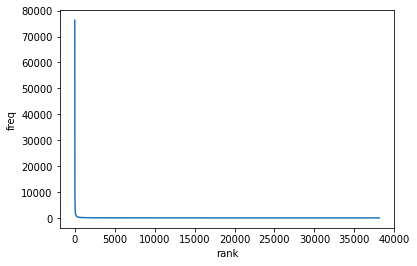

In [ ]:
# plot de frecuencia vs ranking (la palabra mas frecuente tiene rank=1, la segunda tiene rank=2, etc..)
plt.plot(range(len(word_freq)), word_freq)
plt.xlabel("rank")
plt.ylabel("freq")


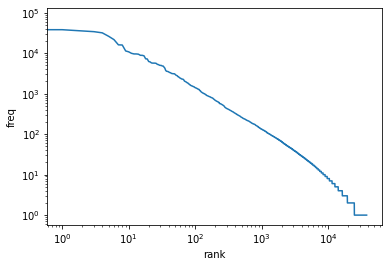

In [ ]:
# ahora en eje logaritmico
plt.plot(range(len(word_freq)), word_freq)
plt.xlabel("rank")
plt.ylabel("freq")
plt.xscale("log")
plt.yscale("log")


In [ ]:
# palabras con 1 sola occurrencia
print(
    "el ",
    round(100 * sum(word_freq == 1) / len(word_freq), 2),
    "% de las palabras aparecen 1 sola vez",
)


el  34.82 % de las palabras aparecen 1 sola vez


In [ ]:
print(
    "las 10 palabras mas frecuentes representan el ",
    round(100 * word_freq[:10].sum() / word_freq.sum(), 2),
    "% del corpus",
)


las 10 palabras mas frecuentes representan el  24.05 % del corpus
